In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import influence_plot
import seaborn as sns

In [2]:
df=pd.read_csv("D:\\DATA_science\\DATA_science assignment\\Mul_Lin_Reg\\50_Startups.csv")

In [12]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.3+ KB


In [14]:
df.corr()

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing Spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


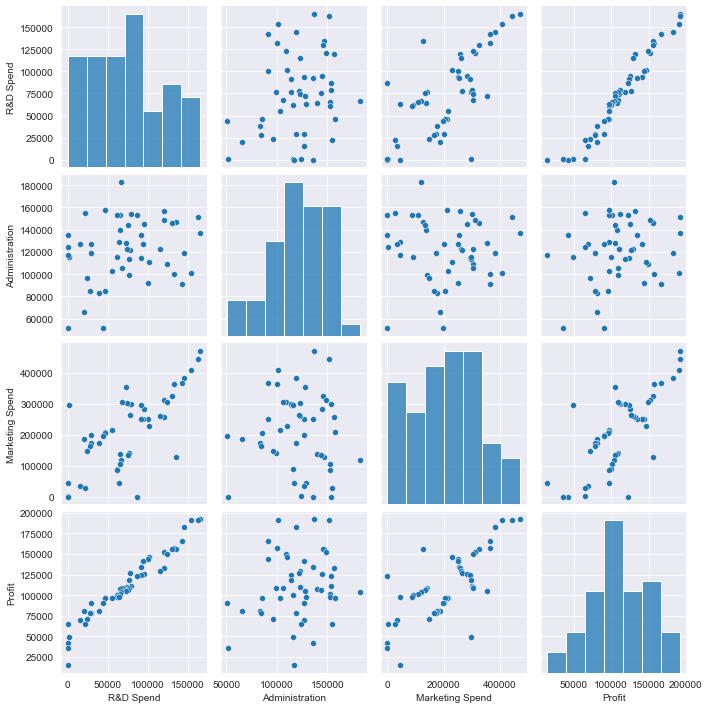

In [15]:
sns.set_style(style='darkgrid')
sns.pairplot(df)

In [23]:
df1=df.rename(columns={'R&D Spend':'RD','Administration':'Adm','Marketing Spend':'MS'})
df1.head()

,RD,Adm,MS,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## MOdel Preparation

In [25]:
model=smf.ols('Profit~RD+Adm+MS',data=df1).fit()

In [26]:
model.params

Intercept    50122.192990
RD               0.805715
Adm             -0.026816
MS               0.027228
dtype: float64

In [27]:
model.tvalues,model.pvalues

(Intercept     7.626218
 RD           17.846374
 Adm          -0.525507
 MS            1.655077
 dtype: float64,
 Intercept    1.057379e-09
 RD           2.634968e-22
 Adm          6.017551e-01
 MS           1.047168e-01
 dtype: float64)

In [28]:
## Coefficients of administration and marketing spend are not contributing in fitiing the model 
## Let's check which one gives better model

In [29]:
model.rsquared,model.rsquared_adj

(0.9507459940683246, 0.9475337762901719)

### Simple LR

In [32]:
model_MS=smf.ols('Profit~MS',data=df1).fit()

In [37]:
model_MS.tvalues,model_MS.pvalues

(Intercept    7.808356
 MS           7.802657
 dtype: float64,
 Intercept    4.294735e-10
 MS           4.381073e-10
 dtype: float64)

In [38]:
model_MS.rsquared

0.5591535746115515

In [40]:
model_Adm=smf.ols('Profit~Adm',data=df1).fit()

In [41]:
model_Adm.pvalues

Intercept    0.003824
Adm          0.162217
dtype: float64

In [42]:
model_Adm.rsquared

0.04028714077757245

# Calculating VIF

In [44]:
rsq_RD = smf.ols('RD~Adm+MS',data=df1).fit().rsquared  
vif_RD = 1/(1-rsq_RD) # 16.33

rsq_Adm = smf.ols('Adm~RD+MS',data=df1).fit().rsquared  
vif_Adm = 1/(1-rsq_Adm) # 564.98

rsq_MS = smf.ols('MS~RD+Adm',data=df1).fit().rsquared  
vif_MS = 1/(1-rsq_MS) #  564.84

# Storing vif values in a data frame
d1 = {'Variables':['RD','Adm','MS'],'VIF':[vif_RD,vif_Adm,vif_MS]}
Vif_frame = pd.DataFrame(d1)  
Vif_frame

,Variables,VIF
0,RD,2.468903
1,Adm,1.175091
2,MS,2.326773


## Residual Analysis

## Test for Normality of Residuals (Q-Q Plot)

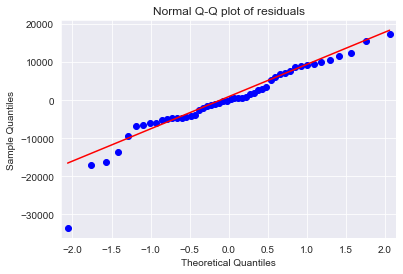

In [45]:
import statsmodels.api as sm
qqplot=sm.qqplot(model.resid,line='q') # line = 45 to draw the diagnoal line
plt.title("Normal Q-Q plot of residuals")
plt.show()

In [46]:

list(np.where(model.resid<-12000))

[array([14, 15, 48, 49], dtype=int64)]

## Residual plot for Homoscedasity

In [47]:
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()

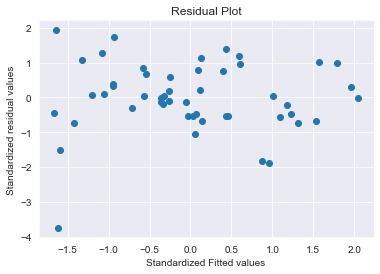

In [48]:
plt.scatter(get_standardized_values(model.fittedvalues),
            get_standardized_values(model.resid))

plt.title('Residual Plot')
plt.xlabel('Standardized Fitted values')
plt.ylabel('Standardized residual values')
plt.show()

## Residual Vs Regressors

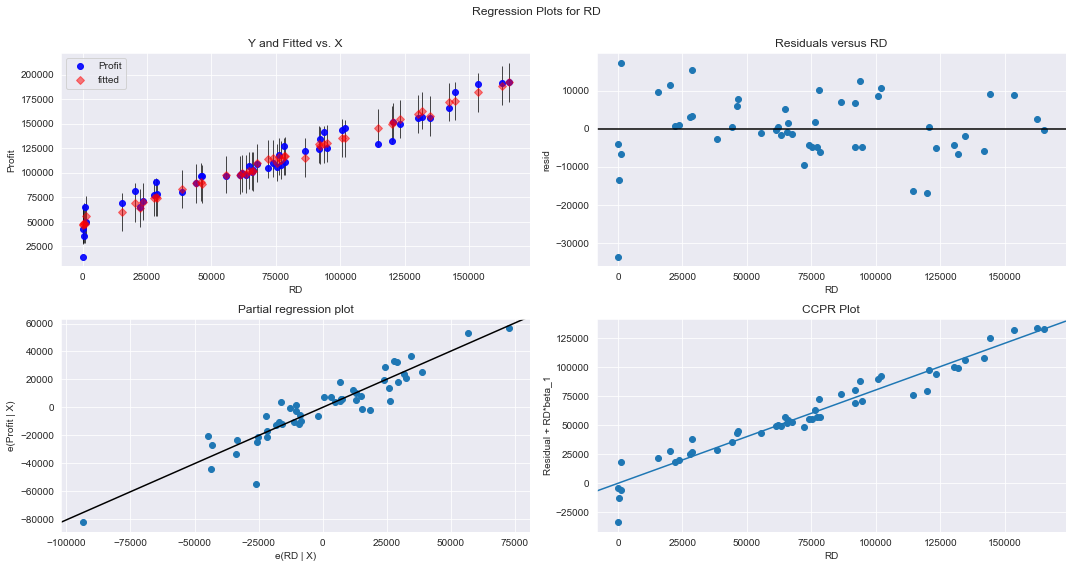

In [49]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "RD", fig=fig)
plt.show()

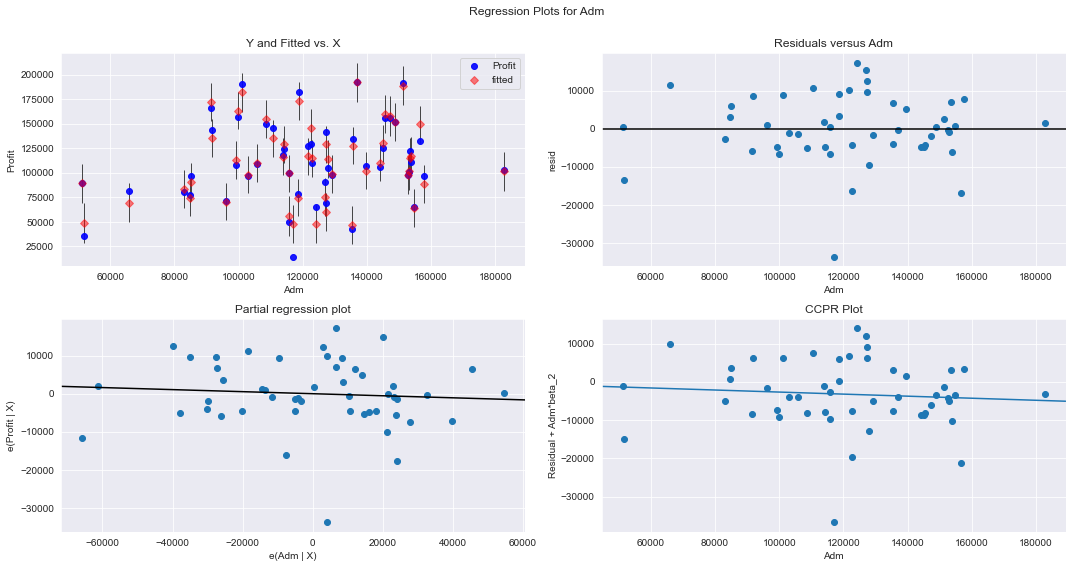

In [50]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "Adm", fig=fig)
plt.show()

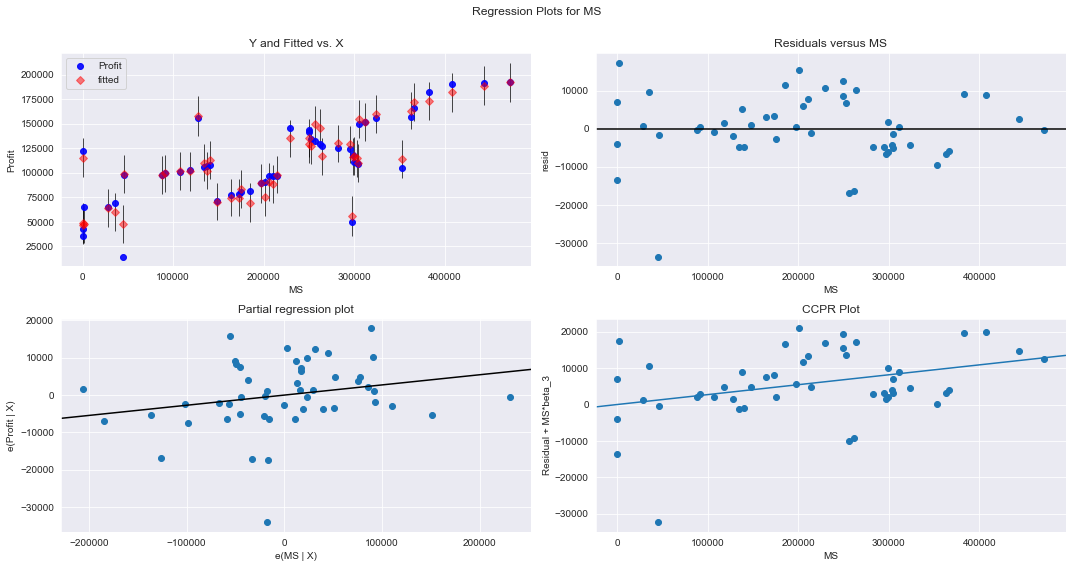

In [51]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "MS", fig=fig)
plt.show()

## Model Deletion Diagnostics


### Detecting Influencers/Outliers


#### Cook’s Distance

In [52]:
model_influence = model.get_influence()
(c, _) = model_influence.cooks_distance

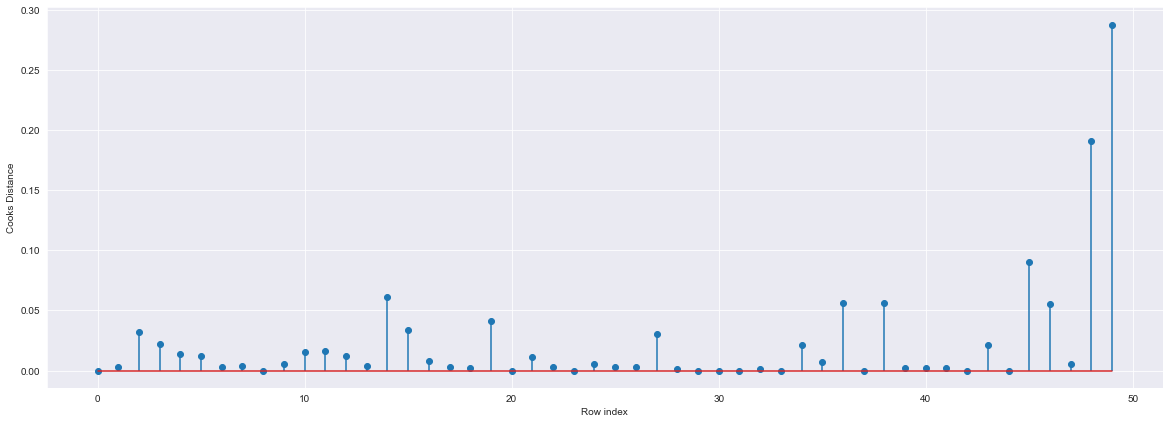

In [54]:
#Plot the influencers values using stem plot
fig = plt.subplots(figsize=(20, 7))
plt.stem(np.arange(len(df1)), np.round(c, 3))
plt.xlabel('Row index')
plt.ylabel('Cooks Distance')
plt.show()

In [57]:
#index and value of influencer where c at max
(np.argmax(c),np.max(c))

(49, 0.28808229275432634)

## High Influence Points

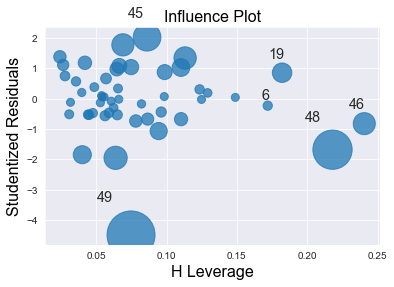

In [58]:
from statsmodels.graphics.regressionplots import influence_plot
influence_plot(model)
plt.show()

In [59]:
k = df.shape[1]
n = df.shape[0]
leverage_cutoff = 3*((k + 1)/n)
leverage_cutoff 

0.36

In [62]:
df1[df1.index.isin([48, 49, 46, 19])]

,RD,Adm,MS,State,Profit
19,86419.70,153514.11,0.00,New York,122776.86
46,1315.46,115816.21,297114.46,Florida,49490.75
48,542.05,51743.15,0.00,New York,35673.41
49,0.00,116983.80,45173.06,California,14681.40


In [64]:
#See the differences in HP and other variable values
df1.head()

,RD,Adm,MS,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## Improving the Model

In [65]:
#Discard the data points which are influencers and reasign the row number (reset_index())
df2=df1.drop(df1.index[[19,46,48,49]],axis=0).reset_index()

In [66]:
#Drop the original index
df2=df2.drop(['index'],axis=1)

In [67]:
df2.head()

,RD,Adm,MS,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [68]:
df3=df2.drop(df2.index[[45]],axis=0).reset_index()

In [69]:
df4=df3.drop(['index'],axis=1)

## Build Model

In [70]:
Model_Adm=smf.ols('Profit~RD+Adm',data=df4).fit()

In [71]:
Model_Adm.rsquared,model_Adm.aic

(0.9562893577513291, 1203.2536701858016)

In [72]:
Model_MS=smf.ols('Profit~RD+MS',data=df4).fit()

In [73]:
Model_MS.rsquared,model_MS.aic

(0.9585308276399593, 1164.3567921009328)

 ## Comparing above R-Square and AIC values, model 'model_MS' has high R- square and low AIC value hence include variable 'MS' so that multi collinearity problem would be resolved.¶

In [ ]:
## Upto to this is final RSquared without applying transformations , now I appy transformations on df2

In [74]:
df4.head()

,RD,Adm,MS,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [85]:
import math
df5=df4[["RD","Adm","MS","Profit"]]
df5.transform(func=lambda x : (1/(x*x))).head()

,RD,Adm,MS,Profit
0,3.657597e-11,5.335892e-11,4.492762e-12,2.705290e-11
1,3.782433e-11,4.363920e-11,5.074960e-12,2.718559e-11
2,4.247313e-11,9.774768e-11,6.009233e-12,2.739707e-11
3,4.797683e-11,7.100756e-11,6.810043e-12,2.989256e-11
4,4.951844e-11,1.197253e-10,7.458272e-12,3.620770e-11


In [86]:
model_df5=smf.ols('Profit~RD+MS+Adm',data=df5).fit()

In [87]:
model_df5.rsquared

0.9597068086420004

In [100]:
to_log=['Profit','RD','Adm','MS']
df5_log_log=df5[to_log].applymap(lambda x: np.log(np.log(x+1)))

In [101]:
model_df5_log_log=smf.ols('Profit~RD+MS+Adm',data=df5_log_log).fit()

In [102]:
model_df5_log_log.rsquared

0.6284276974370147

In [103]:
to_log=['Profit','RD','Adm','MS']
df5_log=df5[to_log].applymap(lambda x: (np.log(x+1)))

In [104]:
model_df5_log=smf.ols('Profit~RD+MS+Adm',data=df5_log).fit()

In [105]:
model_df5_log.rsquared

0.7033054097489777

In [113]:
df5_exp=df5.applymap(lambda x: math.exp(1/x))

In [114]:
model_exp_df5=smf.ols('Profit~RD+MS+Adm',data=df5_exp).fit()

In [115]:
model_exp_df5.rsquared

0.27631633187569127

In [122]:
df5_1_exp=df5.applymap(lambda x: 1/(math.exp(1/x)))

In [123]:
model_1_exp_df5=smf.ols('Profit~RD+MS+Adm',data=df5_1_exp).fit()

In [124]:
model_1_exp_df5.rsquared

0.27654470883569515

In [126]:
d2={'Transformations':['No transformation','By Del Adm','By Del MS','Inverse of X^2','log(x+1)','log(log(x+1))','EXP(1/x)','Inv(EXP(1/x))'],
   'R Squared':[model.rsquared,Model_MS.rsquared,Model_Adm.rsquared,model_df5.rsquared,model_df5_log.rsquared,
                model_df5_log_log.rsquared,model_exp_df5.rsquared,model_1_exp_df5.rsquared]}
pd.DataFrame(d2)

,Transformations,R Squared
0,No transformation,0.950746
1,By Del Adm,0.958531
2,By Del MS,0.956289
3,Inverse of X^2,0.959707
4,log(x+1),0.703305
5,log(log(x+1)),0.628428
6,EXP(1/x),0.276316
7,Inv(EXP(1/x)),0.276545


In [ ]:
## Inverse of X^2 gives us best result without deleting any variable in a dataset.